In [432]:
 !pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tqdm tensorflow numpy pandas matplotlib scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 13.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 15.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

print(tf.__version__)
print('GPU is', tf.config.list_physical_devices())

2024-04-25 16:54:36.922731: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 16:54:36.949741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
GPU is [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-25 16:54:37.722957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 16:54:37.728139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 16:54:37.728281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [395]:
all_data = pd.read_csv('dataset/train.csv', names=['sentiment', 'text'])
all_data = all_data.sample(130000, random_state=0)
# replace sentiment with 0 and 1
all_data['sentiment'] = all_data['sentiment'].replace(1, 0) # Negative
all_data['sentiment'] = all_data['sentiment'].replace(2, 1) # Positive
train = all_data.sample(frac=0.6, random_state=0)
val = all_data.drop(train.index)
test = val.sample(frac=0.5, random_state=0)
val = val.drop(test.index)
print(train.head())

batch_size = 64
test_ds = tf.data.Dataset.from_tensor_slices((test['text'].values, test['sentiment'].values)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val['text'].values, val['sentiment'].values)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((train['text'].values, train['sentiment'].values)).batch(batch_size)

        sentiment                                               text
400911          0  Visiting here to purchase goodies for a GF fri...
401060          1  What's up Doc? A rabbit burger on the brunch m...
509186          1  What can you say its a movie theater. Popcorn ...
440605          0  This place sucks! They forgot to put egg in my...
450298          0  After a long walk on the strip, i was hungry a...


In [442]:
from tensorflow.keras import layers, losses
import re
import string

max_features = 3000
sequence_length = 500

def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'https?://[\w./?&=#-]+', '')
    text = tf.strings.regex_replace(text, r'@\w+', '')
    text = tf.strings.regex_replace(text, r'\\n', ' ')
    text = tf.strings.regex_replace(text, r' +', ' ')
    return tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(train['text'].values)

In [443]:
# retrieve a batch

print(vectorize_layer.get_vocabulary()[:5])
print(vectorize_layer(train_ds.take(1).as_numpy_iterator().next()[0]))

['', '[UNK]', 'the', 'and', 'i']
tf.Tensor(
[[1090   45    5 ...    0    0    0]
 [1096   52    1 ...    0    0    0]
 [  61   77   20 ...    0    0    0]
 ...
 [  15   23   68 ...    0    0    0]
 [   1   71 1475 ...    0    0    0]
 [   1    8  293 ...    0    0    0]], shape=(64, 500), dtype=int64)


In [444]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [445]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [446]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy()])

In [447]:
train_ds2 = train_ds.map(vectorize_text)
val_ds2 = val_ds.map(vectorize_text)
test_ds2 = test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.cache().prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)
test_ds2 = test_ds2.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 10
history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=epochs, batch_size=batch_size,
    validation_steps=30)

Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - binary_accuracy: 0.7589 - loss: 0.4539 - val_binary_accuracy: 0.6797 - val_loss: 0.5172
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - binary_accuracy: 0.7922 - loss: 0.4230 - val_binary_accuracy: 0.9125 - val_loss: 0.2295
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - binary_accuracy: 0.9129 - loss: 0.2266 - val_binary_accuracy: 0.9042 - val_loss: 0.2161
Epoch 4/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - binary_accuracy: 0.9250 - loss: 0.1865 - val_binary_accuracy: 0.9187 - val_loss: 0.1845
Epoch 5/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - binary_accuracy: 0.9354 - loss: 0.1641 - val_binary_accuracy: 0.9276 - val_loss: 0.1949
Epoch 6/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - binary_accuracy: 0.9427 - loss: 0.1448 - val_binary_accuracy: 0.9203 - val_loss: 0.1817
Epoch 7/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - binary_accuracy: 0.9490 - loss: 0.1306 - val_binary_accuracy: 0.91

2024-04-25 19:35:46.415918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [448]:
loss, accuracy = model.evaluate(test_ds2)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print(model.metrics_names)

407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - binary_accuracy: 0.9314 - loss: 0.1915
Loss:  0.192695751786232
Accuracy:  0.9306923151016235
['loss', 'compile_metrics']


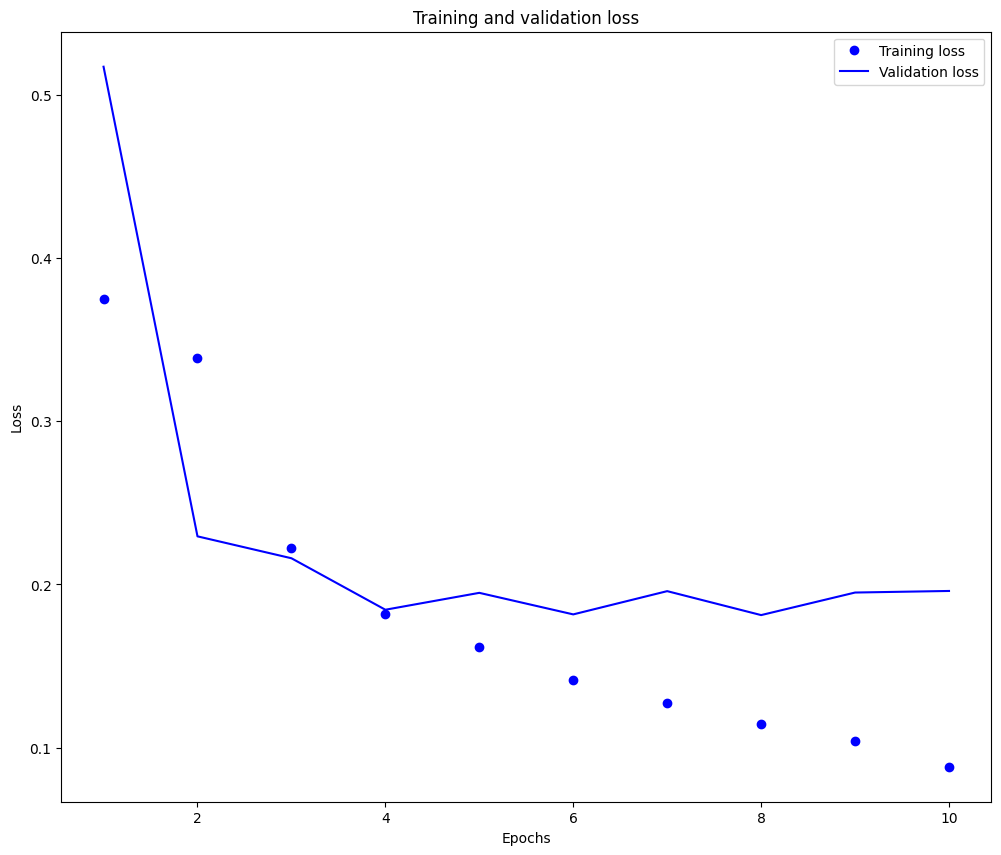

In [449]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

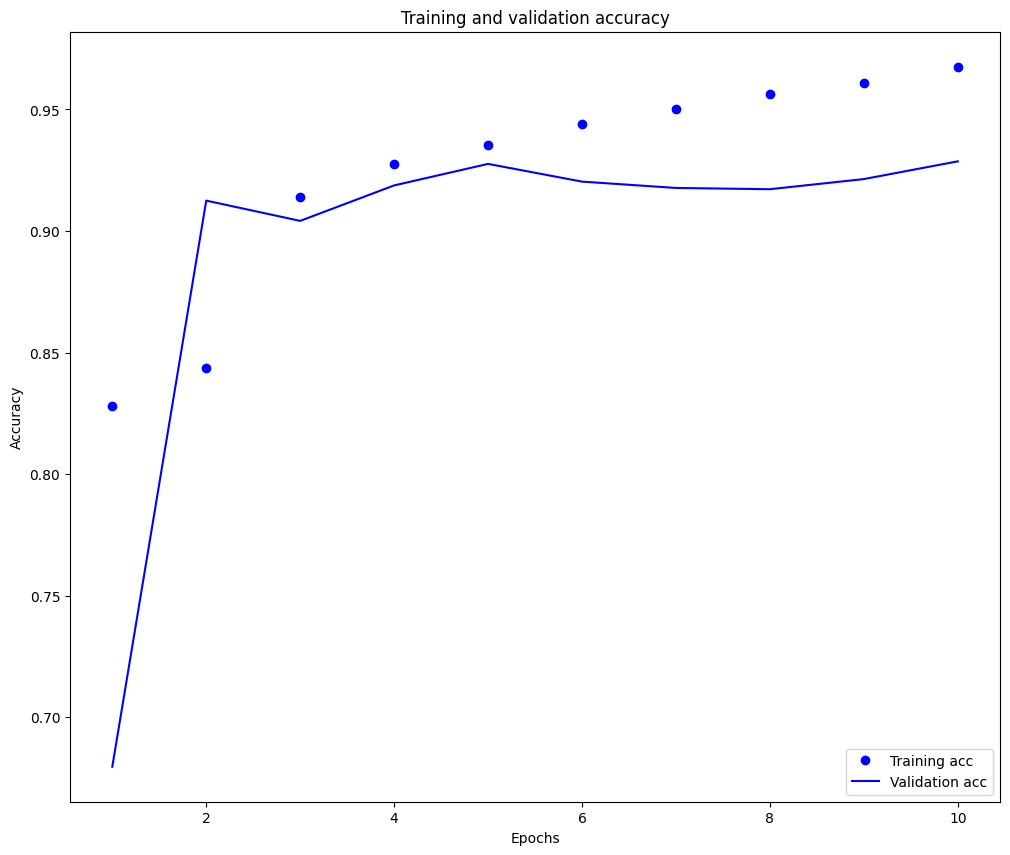

In [450]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


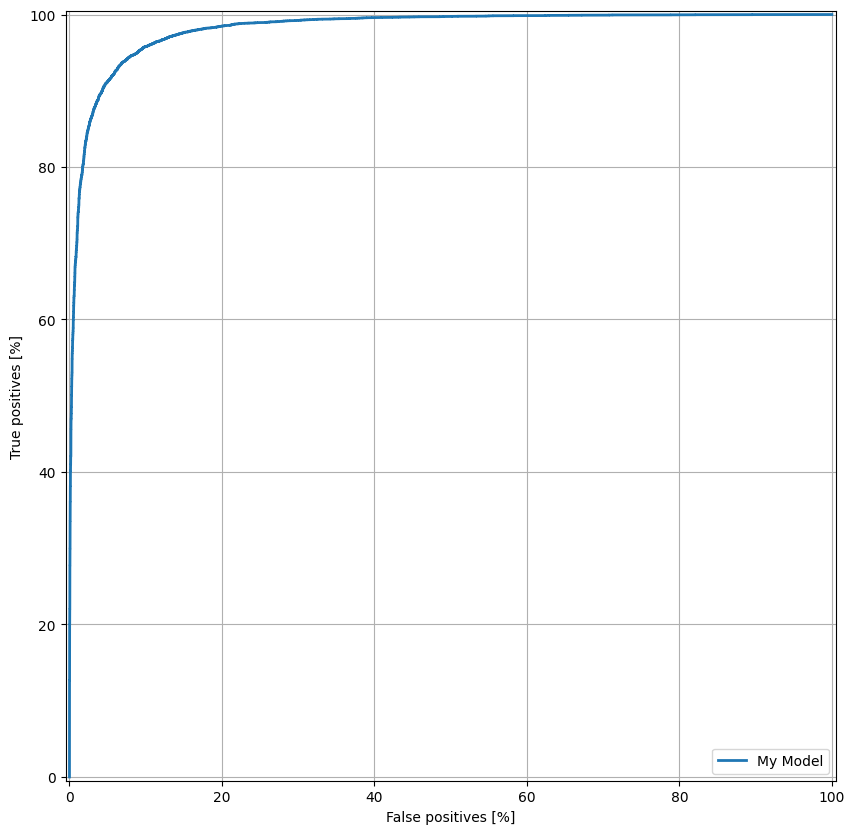

In [451]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
 
# 绘制正例ROC曲线
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions, pos_label=0)
 
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc='lower right')
  plt.show()
 
test_predictions = model.predict(test_ds2)
true_labels=test['sentiment'].values
test_scores = 1-(test_predictions - test_predictions.min())/(test_predictions.max() - test_predictions.min())
    
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("My Model", true_labels, test_scores, color=colors[0])


In [452]:
recall = recall_score(true_labels, test_predictions > 0.5)
precision = precision_score(true_labels, test_predictions > 0.5)
f1 = f1_score(true_labels, test_predictions > 0.5)
accuracy = accuracy_score(true_labels, test_predictions > 0.5)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1: ', f1)
print('Accuracy: ', accuracy)

Recall:  0.9100046389361374
Precision:  0.9485815602836879
F1:  0.928892747218057
Accuracy:  0.9306923076923077


In [463]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

print(export_model.predict(np.array([b'not good'], dtype=object)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[0.01797247]]


In [454]:
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

print(test_ds)
accuracy = export_model.evaluate(test_ds, return_dict=True)
print(accuracy)

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
407/407 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9345 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.9329615235328674, 'binary_accuracy': 0.0, 'loss': 0.0}


In [467]:
# save model
export_model.save('model.keras')